In [1]:
# Install necessary libraries
!pip install ultralytics
!pip install plotly
!pip install opencv-python-headless

import os
import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9

In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='84613b099886afe5ce8f95561b8ba4d641b5c51a')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ar8076488543 (ar8076488543-maharaja-agrasen-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:

# Paths to data directories
train_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train"
val_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val"

In [4]:
# Classes
classes = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

In [5]:
# Function to load images and labels
def load_data(data_path):
    images = []
    labels = []
    for class_label in classes:
        class_path = os.path.join(data_path, class_label, 'images')
        label_path = os.path.join(data_path, class_label, 'labels')
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_file = img_file.replace('.jpg', '.txt')
            label_file_path = os.path.join(label_path, label_file)
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip().split()
                    if len(label_data) > 0:
                        images.append(img)
                        labels.append(label_data)
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    return images, labels

# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/labels/gg (342).txt is empty, skipping this image.
Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/labels/image(61).txt not found, skipping this image.
Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/labels/image(55).txt not found, skipping this image.


In [6]:
# EDA - Visualize class distribution
train_counts = [len(os.listdir(os.path.join(train_path, cls, 'images'))) for cls in classes]
val_counts = [len(os.listdir(os.path.join(val_path, cls, 'images'))) for cls in classes]
eda_df = pd.DataFrame({'Class': classes, 'Train': train_counts, 'Validation': val_counts})

fig = go.Figure(data=[
    go.Bar(name='Train', x=eda_df['Class'], y=eda_df['Train']),
    go.Bar(name='Validation', x=eda_df['Class'], y=eda_df['Validation'])
])
fig.update_layout(barmode='group', title='Class Distribution in Training and Validation Sets')
fig.show()

In [7]:
# Image Preprocessing
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (640, 640))
        processed_images.append(img_resized)
    return np.array(processed_images)

train_images = preprocess_images(train_images)
val_images = preprocess_images(val_images)

In [8]:
# Create YOLOv8 Dataset Configuration File
dataset_yaml = {
    'path': '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes',
    'train': 'Train',
    'val': 'Val',
    'names': classes
}

with open('/kaggle/working/dataset.yaml', 'w') as file:
    yaml.dump(dataset_yaml, file)

In [9]:
# YOLOv8 Model Training
yolo_model = YOLO("yolov8s.pt")  # Load a pre-trained YOLOv8 model
train_results = yolo_model.train(data='/kaggle/working/dataset.yaml', epochs=30, imgsz=640)

100%|██████████| 21.5M/21.5M [00:00<00:00, 116MB/s] 


Ultralytics 8.3.126 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

100%|██████████| 755k/755k [00:00<00:00, 28.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 88.2±36.1 MB/s, size: 37.3 KB)


train: Scanning /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Glioma/labels... 4737 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4737/4737 [00:03<00:00, 1186.91it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Glioma is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 38.3±25.2 MB/s, size: 26.3 KB)


val: Scanning /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/labels... 510 images, 3 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<00:00, 801.85it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.36G      1.043      1.773      1.246          1        640: 100%|██████████| 297/297 [01:32<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]

                   all        512        554      0.741      0.759      0.811      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.36G      1.053      1.075      1.233          4        640: 100%|██████████| 297/297 [01:29<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]

                   all        512        554      0.806      0.701      0.815      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.36G      1.056      1.017      1.228          0        640: 100%|██████████| 297/297 [01:29<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]

                   all        512        554      0.816       0.77      0.832      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.36G      1.031     0.9631      1.225          2        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  4.00it/s]

                   all        512        554      0.802      0.807      0.862      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.36G     0.9849     0.8563      1.184          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]

                   all        512        554      0.822      0.711      0.798      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.36G     0.9541     0.8038      1.175          2        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]

                   all        512        554      0.896       0.86      0.912      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.36G     0.9151     0.7506       1.15          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.10it/s]

                   all        512        554      0.873      0.847      0.905      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.36G     0.9196      0.737       1.15          5        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.07it/s]

                   all        512        554      0.935      0.839      0.929       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.36G     0.8986     0.6784      1.134          4        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.15it/s]

                   all        512        554      0.893        0.9      0.938      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.36G     0.8904     0.6851      1.135          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.00it/s]

                   all        512        554       0.91      0.892      0.933      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.36G     0.8758     0.6502       1.13          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.09it/s]

                   all        512        554       0.92      0.872      0.935      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.36G     0.8693     0.6419      1.122          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.11it/s]

                   all        512        554      0.932      0.909      0.949      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.36G     0.8554     0.6256      1.111          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.09it/s]

                   all        512        554      0.923      0.898      0.952      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.36G     0.8504     0.6007      1.114          2        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.08it/s]

                   all        512        554      0.897      0.927      0.948      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.36G      0.831     0.5908      1.103          2        640: 100%|██████████| 297/297 [01:28<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.01it/s]

                   all        512        554      0.932      0.906      0.953      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.36G     0.8217     0.5742      1.096          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]

                   all        512        554      0.941      0.911      0.955      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.36G     0.8152     0.5515      1.098          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  4.00it/s]

                   all        512        554      0.925      0.932      0.959      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.36G     0.7886     0.5425      1.079          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]

                   all        512        554      0.945       0.89      0.954      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.36G     0.7876     0.5177      1.073          3        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]

                   all        512        554      0.936      0.914      0.953      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.36G     0.7737     0.5104      1.073          2        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.07it/s]

                   all        512        554      0.948      0.917      0.963      0.773


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.36G      0.741     0.4619      1.052          1        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.07it/s]

                   all        512        554      0.933      0.932      0.961      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.36G     0.7239     0.4324      1.041          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.03it/s]

                   all        512        554      0.945       0.91      0.952      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.36G      0.712     0.4251      1.034          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]

                   all        512        554      0.933      0.937      0.961      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.36G      0.698     0.3994      1.022          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.03it/s]

                   all        512        554      0.961      0.911      0.961      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.36G     0.6775     0.3906      1.009          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.10it/s]

                   all        512        554      0.933      0.943      0.963      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.36G     0.6709     0.3718      1.007          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.07it/s]

                   all        512        554      0.945      0.938      0.962      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.36G     0.6633     0.3581      1.005          2        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.09it/s]

                   all        512        554      0.939      0.933      0.966      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.36G     0.6506     0.3492     0.9991          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.87it/s]

                   all        512        554      0.943      0.945      0.966      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.36G     0.6431       0.34     0.9896          1        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]

                   all        512        554      0.943      0.942      0.968      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.36G     0.6278     0.3349     0.9815          2        640: 100%|██████████| 297/297 [01:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.15it/s]

                   all        512        554      0.944      0.942      0.966      0.802



30 epochs completed in 0.778 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]


                   all        512        554      0.944      0.943      0.966      0.803
                Glioma        135        153      0.929      0.889      0.943      0.779
            Meningioma        140        142       0.97          1      0.993      0.852
              No Tumor         98         98      0.975       0.98      0.988      0.839
             Pituitary        154        161      0.901      0.903      0.939       0.74


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


In [10]:
# Save the YOLOv8 model
yolo_model.save('/kaggle/working/yolov8_model.pt')


0: 640x640 1 Glioma, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


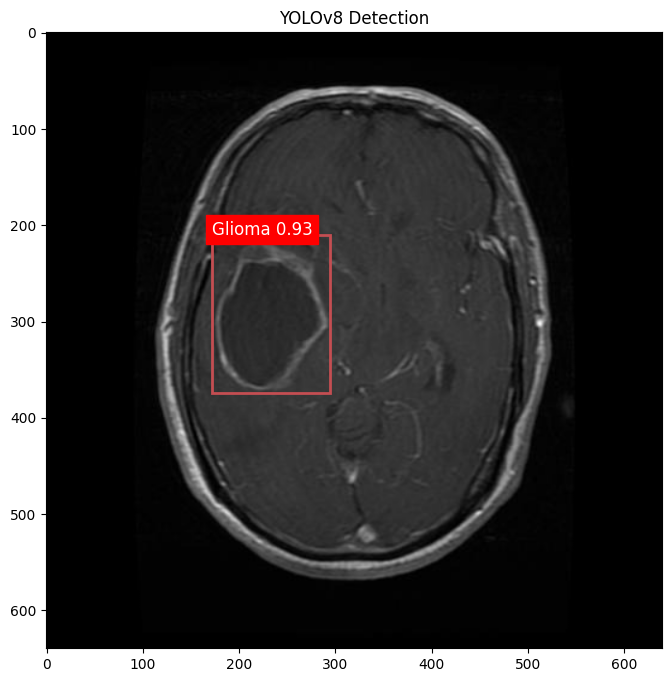


0: 640x640 1 Glioma, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


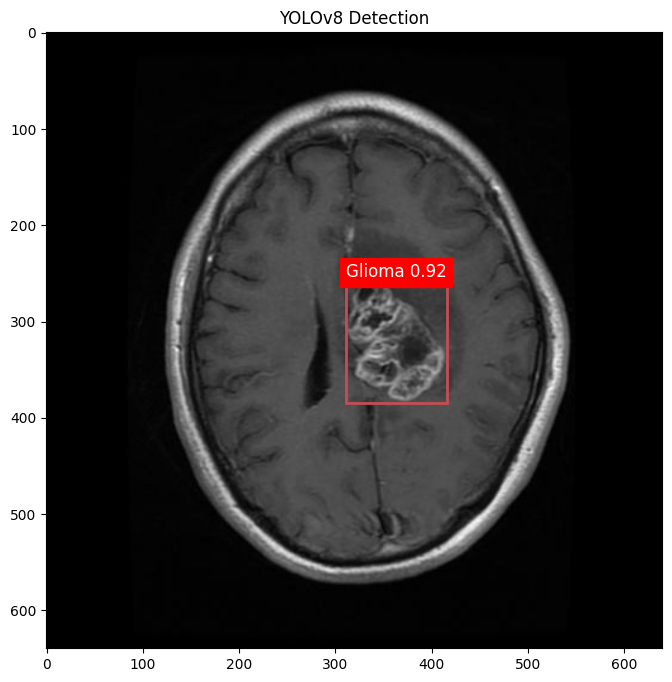


0: 640x640 1 Glioma, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


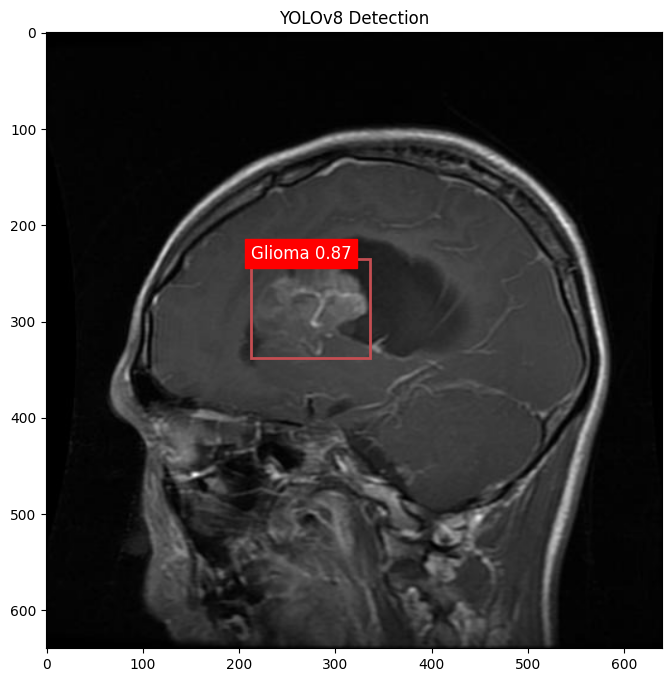


0: 640x640 1 Glioma, 1 Pituitary, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


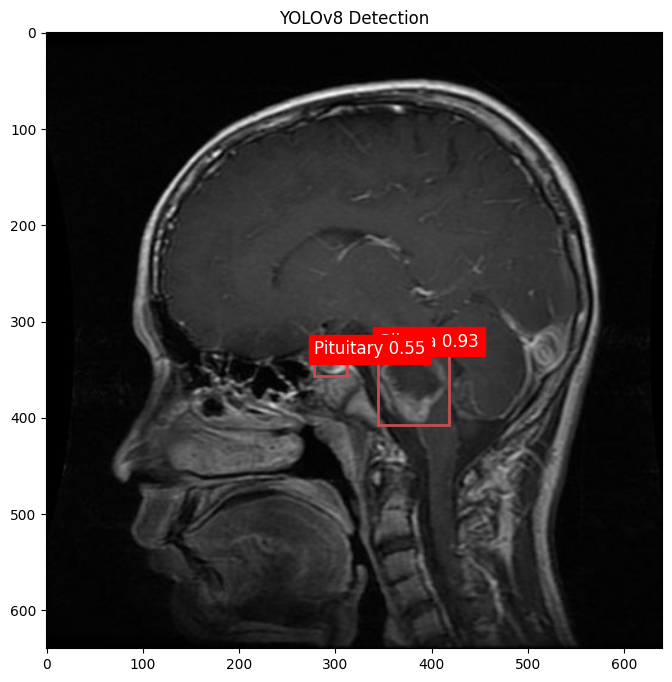


0: 640x640 1 Glioma, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


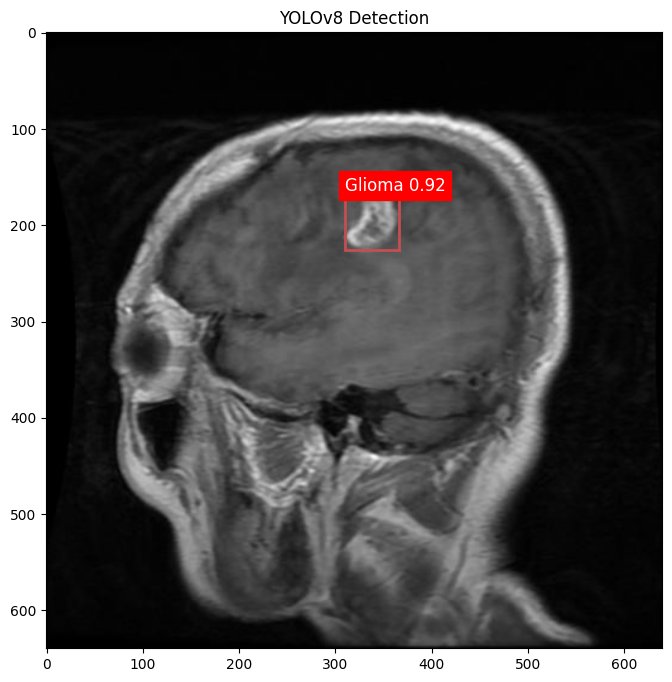


0: 640x640 1 Glioma, 1 Pituitary, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


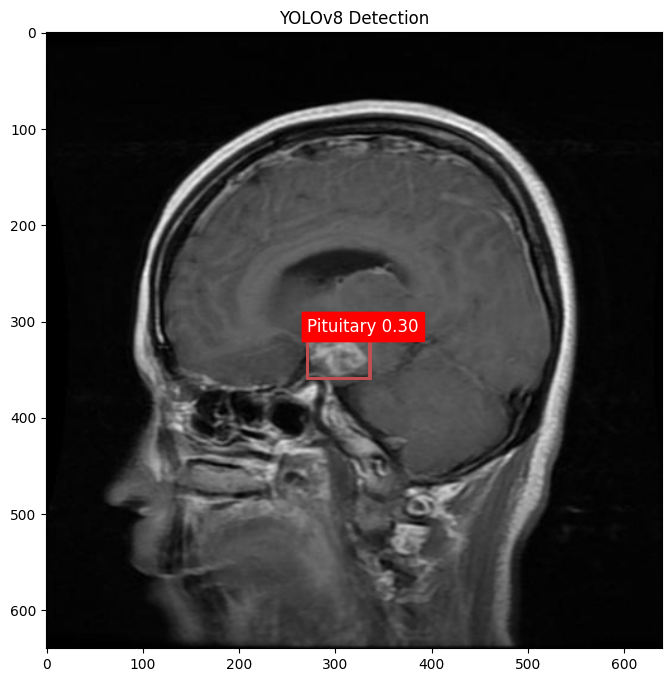


0: 640x640 1 Glioma, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


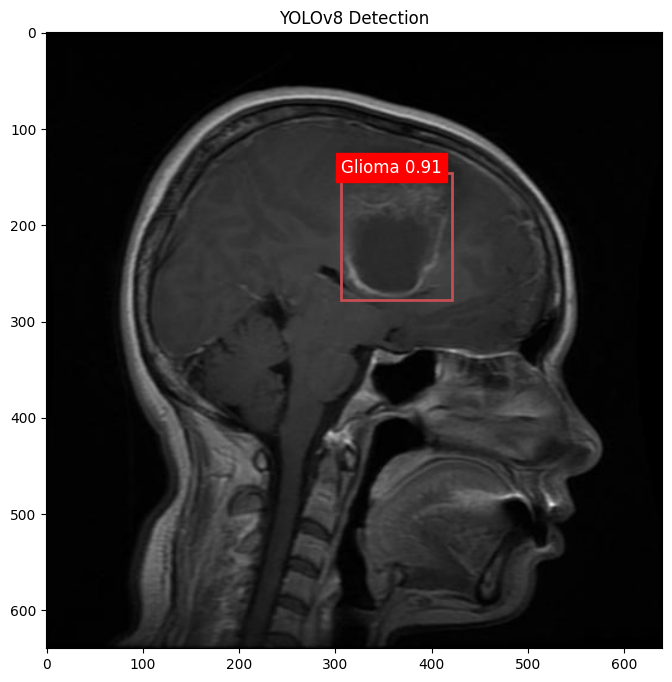


0: 640x640 1 Glioma, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


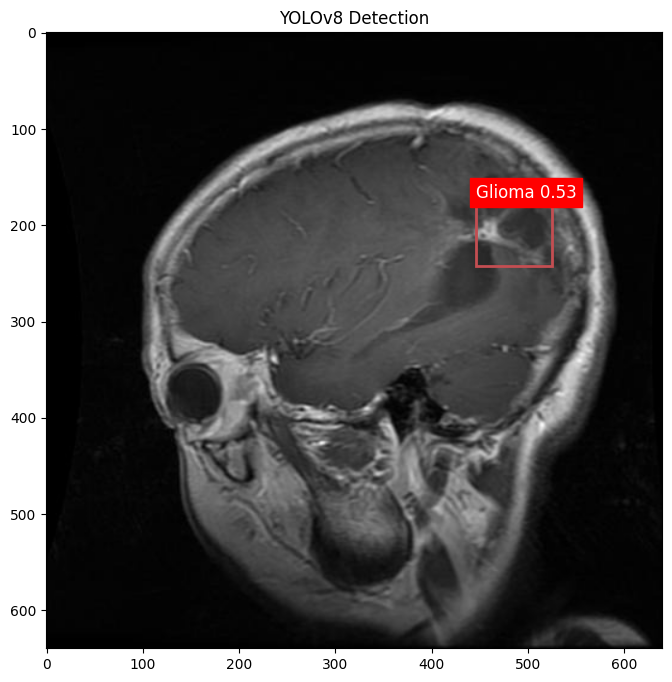


0: 640x640 1 Glioma, 1 Pituitary, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


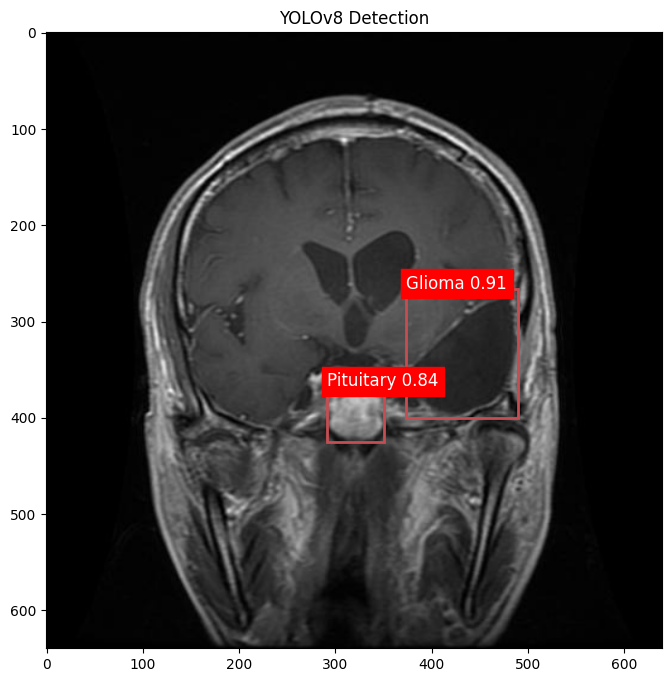


0: 640x640 1 Glioma, 1 Pituitary, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


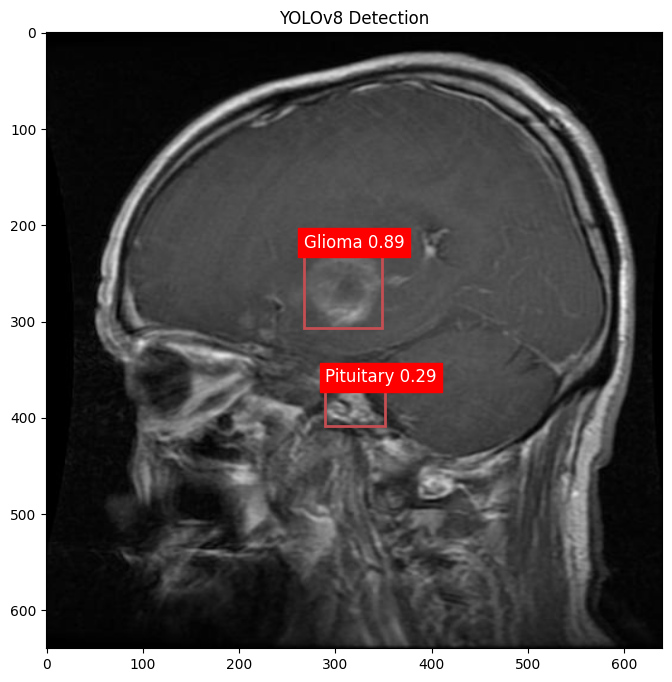

In [11]:
# Function to display detection results with highlighted parts
def display_samples(images, yolo_model):
    for i in range(10):
        img = images[i]
        result = yolo_model.predict(img)[0]  # Assuming batch size of 1, take the first result

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        ax = plt.gca()

        for detection in result.boxes:
            x1, y1, x2, y2 = detection.xyxy[0].cpu().numpy()
            conf = detection.conf[0].cpu().numpy()
            cls = detection.cls[0].cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f"{classes[int(cls)]} {conf:.2f}", color='white', fontsize=12, backgroundcolor='red')
        
        plt.title(f'YOLOv8 Detection')
        plt.show()

display_samples(val_images, yolo_model)